In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scikitplot as skplt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Loading the Dataset

In [2]:
df=pd.read_csv('PS_20174392719_1491204439457_log.csv')
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [3]:
cm=confusion_matrix(df['isFraud'],df['isFlaggedFraud'])
print(cm)

[[6354407       0]
 [   8197      16]]


In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

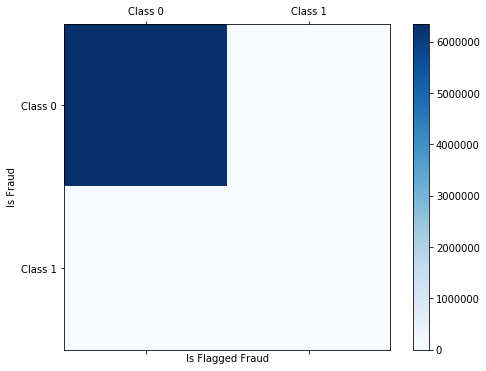

In [5]:
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Is Flagged Fraud')
plt.ylabel('Is Fraud')
plt.show()

In [6]:
print(classification_report(df['isFraud'],df['isFlaggedFraud']))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00   6354407
          1       1.00      0.00      0.00      8213

avg / total       1.00      1.00      1.00   6362620



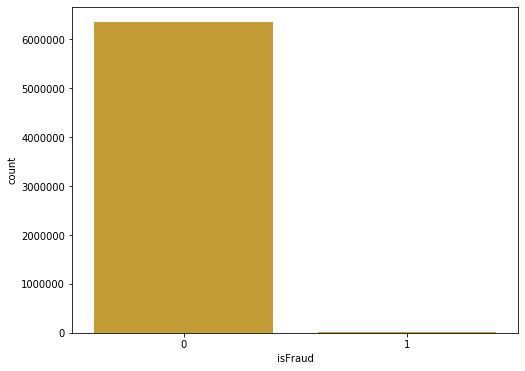

In [7]:
sns.countplot(df['isFraud'],color='goldenrod')

In [8]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

#### From confusion matrix and above bar graph we can tell that our data is highly imbalanced. 

## Applying EDA techniques to get some insights from the data

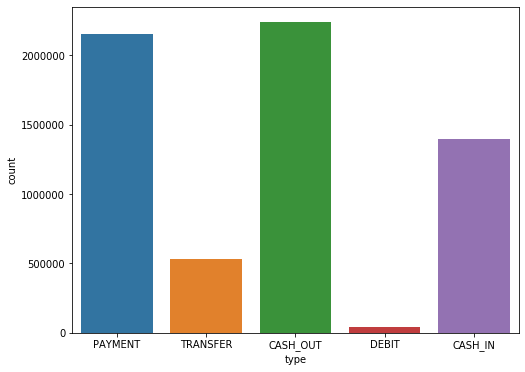

In [9]:
sns.countplot(df['type'])

Text(0, 0.5, 'count')

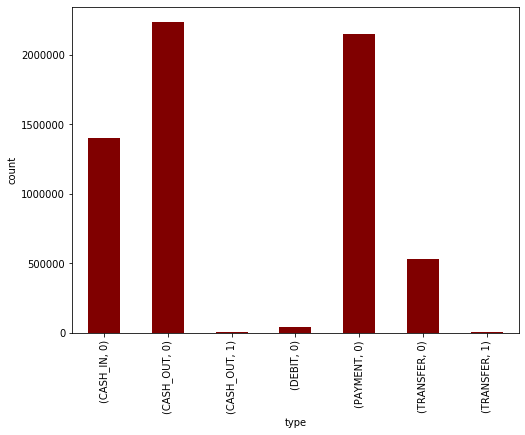

In [10]:
df.groupby(['type','isFraud'])['isFraud'].count().plot(kind='bar',color='maroon')
plt.xlabel('type')
plt.ylabel('count')

### From the above graph we can tell that there were no frauds detected when transaction was of type 'cash_in', 'debit' and 'payment' i.e  fraud mostly happens when payment type is either 'Cash-out' or 'Transfer'

In [11]:
df['nameOrig_alph']= df['nameOrig'].str.extract(pat='([A-Z])')
print(df['nameOrig_alph'].unique())
df['nameDest_alph']= df['nameDest'].str.extract(pat='([A-Z])')
print(df['nameDest_alph'].unique())

['C']
['M' 'C']


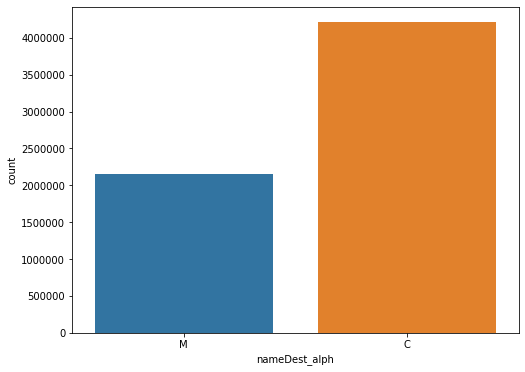

In [12]:
sns.countplot(df['nameDest_alph'])

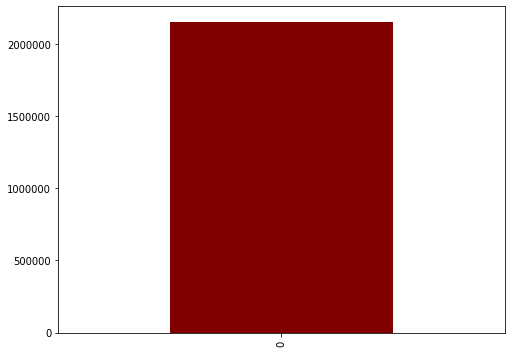

In [13]:
df[df['nameDest_alph']=='M']['isFraud'].value_counts().plot(kind='bar',color='maroon')

### There was no fraud detected when payment was done to a merchant. 

### Keeping only those payments which were initiated by customers and were received by customers other than merchants and were of type 'CASH_OUT' and 'TRANSFER'

In [14]:
df_C=df[df['nameDest_alph']=='C']
train=df_C[(df_C['type']=='CASH_OUT') | (df_C['type']=='TRANSFER')]
train.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,nameOrig_alph,nameDest_alph
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,C,C
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,C,C
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,C,C
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,C,C
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,C,C


In [15]:
data=train.drop(['step','nameOrig','nameDest','nameOrig_alph','nameDest_alph'],axis=1)

In [16]:
data.skew()

amount             21.934943
oldbalanceOrg      70.011751
newbalanceOrig    127.319556
oldbalanceDest     17.160181
newbalanceDest     16.433847
isFraud            18.284510
isFlaggedFraud    416.110262
dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


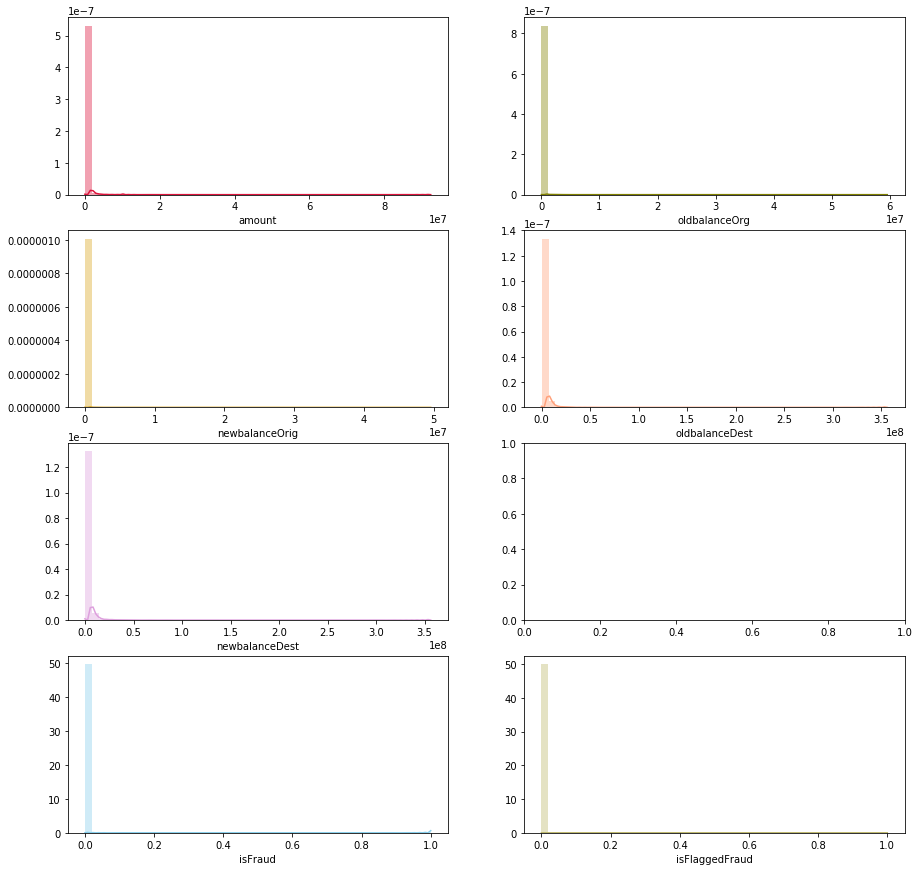

In [17]:
fig, ax = plt.subplots(4,2,figsize = (15,15))
sns.distplot(data["amount"], kde =True, ax=ax[0,0], color = "crimson")
sns.distplot(data["oldbalanceOrg"], kde =True, ax=ax[0,1], color = "olive")
sns.distplot(data["newbalanceOrig"], kde =True, ax=ax[1,0], color = "goldenrod")
sns.distplot(data["oldbalanceDest"], kde =True, ax=ax[1,1], color = "lightsalmon")
sns.distplot(data["newbalanceDest"], kde =True, ax=ax[2,0], color = "plum")
sns.distplot(data["isFraud"], kde =True, ax=ax[3,0],color = 'skyblue')
sns.distplot(data["isFlaggedFraud"], kde =True, ax=ax[3,1],color = 'darkkhaki')

In [18]:
Y1=data['isFraud']
X1=data.loc[:,data.columns!='isFraud']

In [19]:
X1=pd.get_dummies(X1,drop_first=True)

### Data is highly right skewed, we'll now try to reduce the skewness of our data using log transformation

In [20]:
for i in X1.columns:
    X1[i] =np.log(X1[i]+1)

In [21]:
X1=X1.drop('isFlaggedFraud',axis=1)

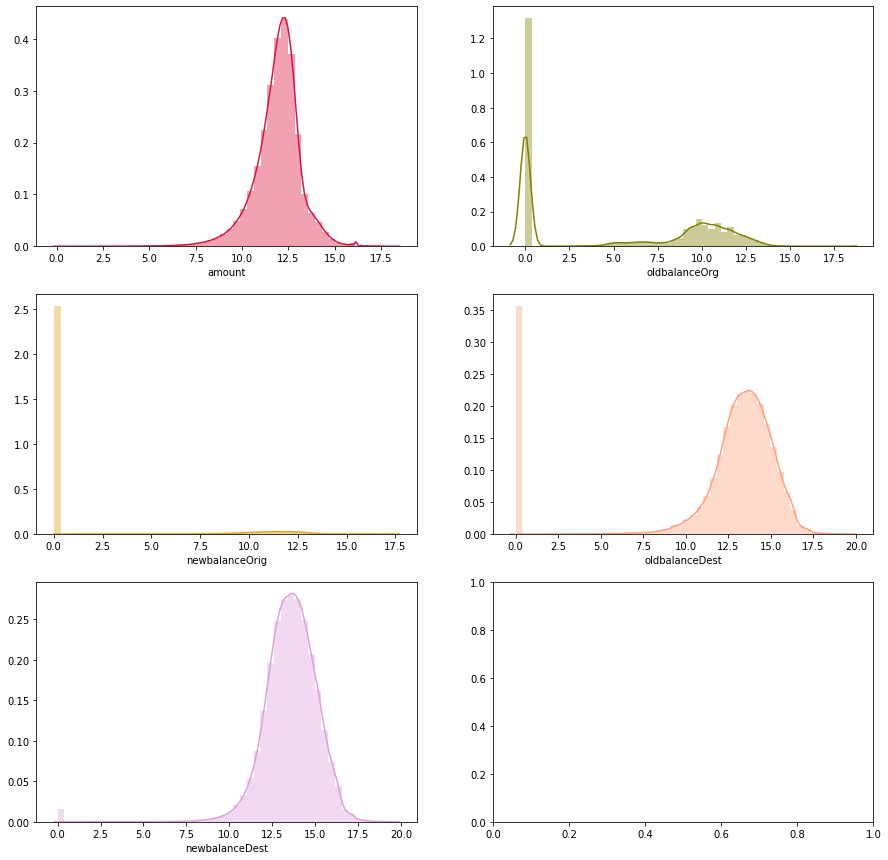

In [22]:
fig, ax = plt.subplots(3,2,figsize = (15,15))
sns.distplot(X1["amount"], kde =True, ax=ax[0,0], color = "crimson")
sns.distplot(X1["oldbalanceOrg"], kde =True, ax=ax[0,1], color = "olive")
sns.distplot(X1["newbalanceOrig"], kde =True, ax=ax[1,0], color = "goldenrod")
sns.distplot(X1["oldbalanceDest"], kde =True, ax=ax[1,1], color = "lightsalmon")
sns.distplot(X1["newbalanceDest"], kde =True, ax=ax[2,0], color = "plum")

In [23]:
X1.skew()

amount           -0.698890
oldbalanceOrg     0.094176
newbalanceOrig    2.787288
oldbalanceDest   -1.703464
newbalanceDest   -2.823009
type_TRANSFER     1.561034
dtype: float64

## Random under-sampling of data using imbalanced-learn

In [24]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

cc = ClusterCentroids(ratio={1:8213, 0: 8213})
X_cc, y_cc = cc.fit_sample(X1, Y1)

plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')

from imblearn.under_sampling import TomekLinks

tl = TomekLinks(return_indices=True, ratio='majority')
X_tl, y_tl = tl.fit_sample(X1, Y1)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

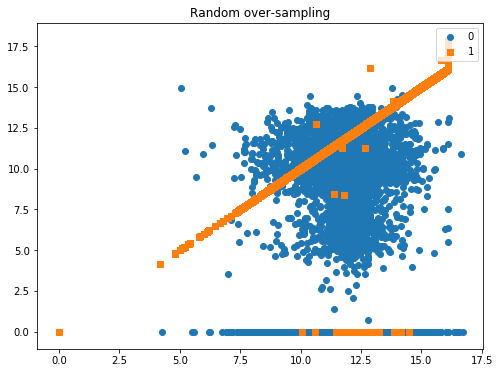

In [82]:
ros = RandomUnderSampler()
X_bal, Y_bal = ros.fit_sample(X1, Y1)

plot_2d_space(X_bal, Y_bal, 'Random over-sampling')

In [26]:
#X_bal.skew()

### Checking for outliers in our data

In [83]:
pd.Series(Y_bal).value_counts()

1    8213
0    8213
dtype: int64

In [84]:
X_bal=pd.DataFrame(X_bal)
X_bal.columns=X1.columns


In [29]:
X_bal.shape

(16426, 6)

In [91]:
data_scale.skew()

amount           -0.543752
oldbalanceOrg    -0.786619
newbalanceOrig    3.925331
oldbalanceDest   -0.316315
newbalanceDest   -1.000832
type_TRANSFER     0.653594
dtype: float64

In [92]:
data_scale.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_TRANSFER
count,1.642600e+04,1.642600e+04,1.642600e+04,1.642600e+04,1.642600e+04,1.642600e+04
mean,1.420214e-13,-6.687630e-15,1.174879e-15,-5.410664e-15,1.289423e-14,-3.827239e-14
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00
min,-7.291652e+00,-1.650839e+00,-2.484615e-01,-1.213631e+00,-1.687352e+00,-7.252673e-01
25%,-5.437052e-01,-6.808350e-01,-2.484615e-01,-1.213631e+00,-1.687352e+00,-7.252673e-01
50%,-2.517114e-02,3.746785e-01,-2.484615e-01,5.699965e-01,4.679102e-01,-7.252673e-01
75%,5.702956e-01,7.259201e-01,-2.484615e-01,8.630694e-01,6.759596e-01,1.378802e+00
max,2.530400e+00,1.605663e+00,5.936927e+00,1.699909e+00,1.492779e+00,1.378802e+00


In [85]:
data_scale = StandardScaler().fit_transform(X_bal)
data_scale=pd.DataFrame(data_scale)
data_scale.columns = X_bal.columns
data_scale.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_TRANSFER
0,-0.556367,0.151401,-0.248462,0.920090,0.652474,-0.725267
1,0.440192,-1.650839,-0.248462,1.010028,0.770890,1.378802
2,-1.903842,-1.650839,-0.248462,0.790177,0.502292,-0.725267
3,-0.568638,-1.650839,-0.248462,0.877078,0.608746,-0.725267
4,-0.493169,-1.650839,-0.248462,0.808217,0.544141,-0.725267


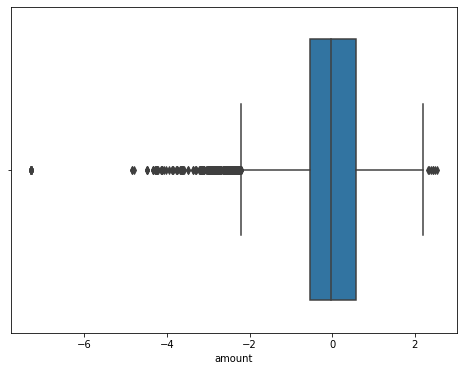

In [86]:
sns.boxplot(data_scale['amount'])

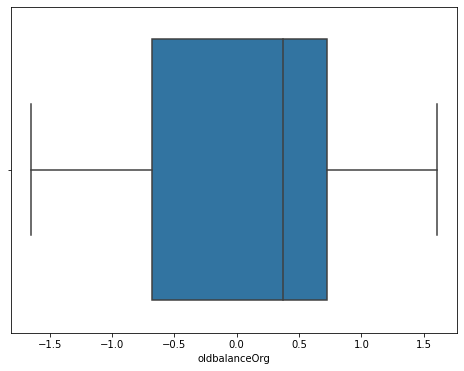

In [87]:
sns.boxplot(data_scale['oldbalanceOrg'])

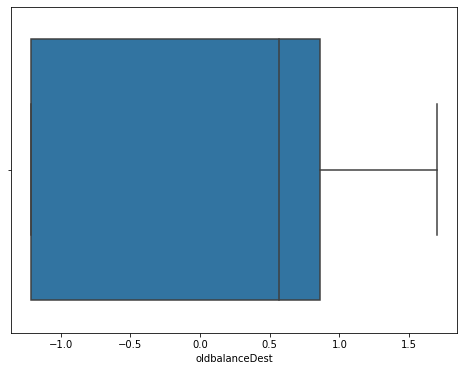

In [90]:
sns.boxplot(data_scale['oldbalanceDest'])

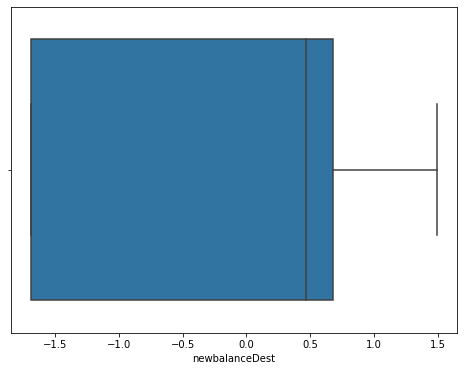

In [36]:
sns.boxplot(data_scale['newbalanceDest'])

In [93]:
Y_bal=pd.Series(Y_bal)

In [94]:
x_y_concat=pd.concat([data_scale,Y_bal],axis=1)

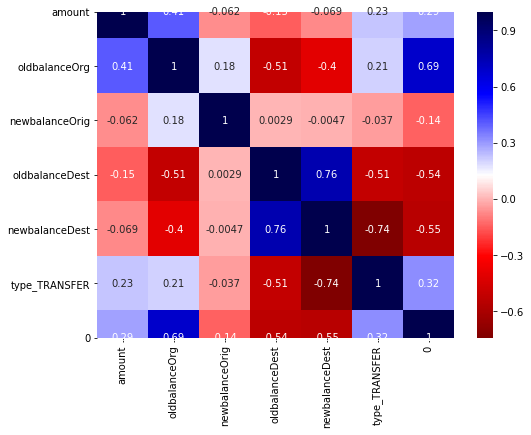

In [95]:
corr=x_y_concat.corr()
sns.heatmap(corr,annot=True,cmap='seismic_r')

## Applying Decision Tree Classifier

In [96]:
x_train,x_test,y_train,y_test = train_test_split(data_scale,Y_bal,test_size=0.2,random_state=42)
clf=DecisionTreeClassifier(criterion= 'entropy')
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
score = accuracy_score(y_test,y_pred)
score

0.9902617163724894

In [44]:
!pip install -q scikit-plot

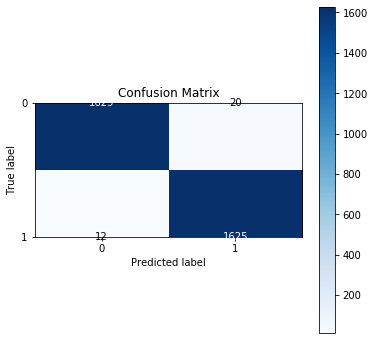

In [97]:
skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred,
    figsize=(6,6))

In [98]:
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[1629   20]
 [  12 1625]]


area under the curve is: 0.9902704773222919


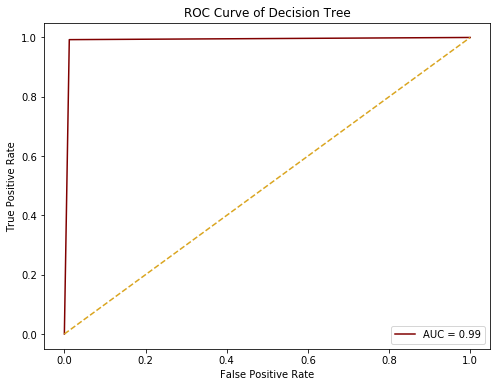

In [99]:
from sklearn.metrics import roc_curve,auc
probability=clf.predict_proba(x_test)
prob_positive=probability[:,1]
fpr,tpr,threshold=roc_curve(y_test,prob_positive)
roc_auc=auc(fpr,tpr) 
print('area under the curve is:',roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'maroon', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],color='goldenrod',linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Decision Tree')
plt.show()

## Applying Random Forest Classifier

In [100]:

rfc=RandomForestClassifier(n_estimators=100,random_state=0)
rfc.fit(x_train,y_train)
y_pred=rfc.predict(x_test)
score=accuracy_score(y_test,y_pred)
score

0.9893487522824103

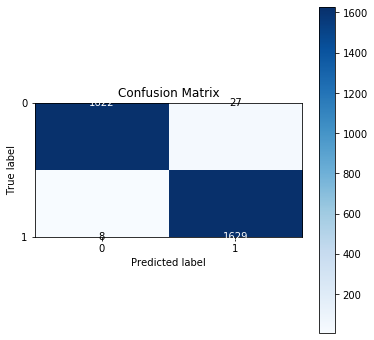

In [101]:
skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred,
    figsize=(6,6))

In [102]:
cm=confusion_matrix(y_test,y_pred)
print(cm)
print(classification_report(y_test,y_pred))

[[1622   27]
 [   8 1629]]
             precision    recall  f1-score   support

          0       1.00      0.98      0.99      1649
          1       0.98      1.00      0.99      1637

avg / total       0.99      0.99      0.99      3286



area under the curve is: 0.9987756597452855


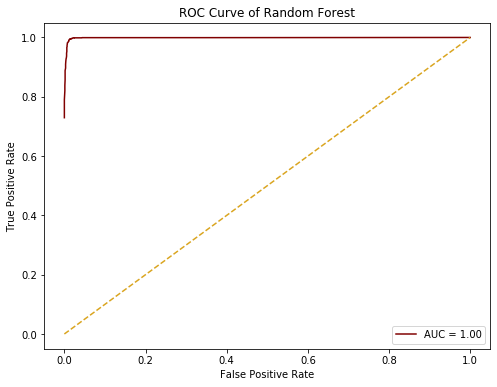

In [103]:
probability=rfc.predict_proba(x_test)
prob_positive=probability[:,1]
fpr,tpr,threshold=roc_curve(y_test,prob_positive)
roc_auc=auc(fpr,tpr) 
print('area under the curve is:',roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'maroon', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],color='goldenrod',linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Random Forest')
plt.show()